In [1]:
%matplotlib inline
import seaborn
import numpy, scipy, IPython.display as ipd, matplotlib.pyplot as plt
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

[&larr; Back to Index](index.html)

# Pitch Transcription Exercise

Load an audio file.

In [2]:
filename = 'audio/simple_piano.wav'
x, sr = librosa.load(filename)

Play the audio file.

In [3]:
ipd.Audio(x, rate=sr)

Display the CQT of the signal.

In [4]:
bins_per_octave = 36
cqt = librosa.cqt(x, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)

In [5]:
cqt.shape

(300, 166)

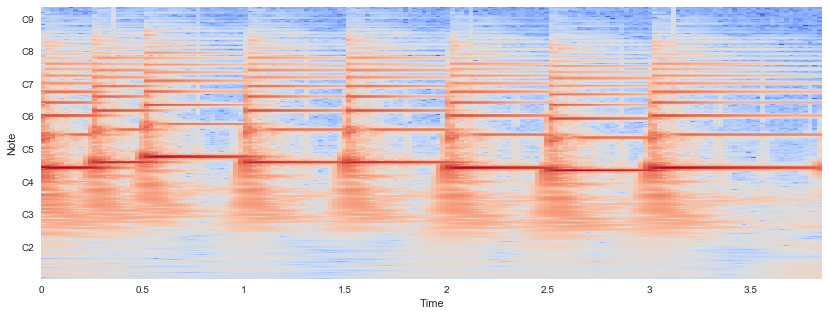

In [6]:
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

**Goal**: Identify the pitch of each note and replace each note with a pure tone of that pitch.

## Step 1: Detect Onsets

To accurately detect onsets, it may be helpful to see what the novelty function looks like:

In [7]:
hop_length = 100
onset_env = librosa.onset.onset_strength(x, sr=sr, hop_length=hop_length)

(0, 850)

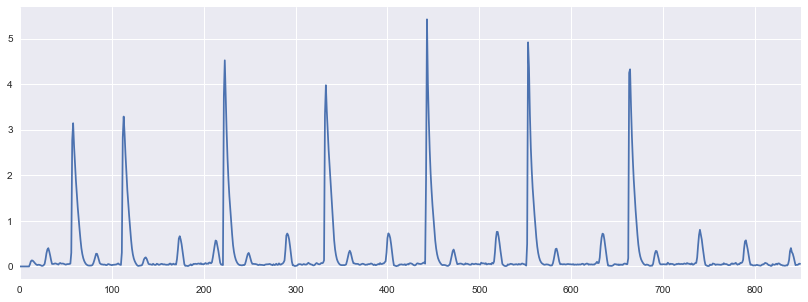

In [8]:
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

Among the obvious large peaks, there are many smaller peaks. We want to choose parameters which preserve the large peaks while ignoring the small peaks.

Next, we try to detect onsets. For more details, see [`librosa.onset.onset_detect`](http://librosa.github.io/librosa/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect) and [`librosa.util.peak_pick`](http://librosa.github.io/librosa/generated/librosa.util.peak_pick.html#librosa.util.peak_pick).

In [9]:
onset_samples = librosa.onset.onset_detect(x,
                                           sr=sr, units='samples', 
                                           hop_length=hop_length, 
                                           backtrack=False,
                                           pre_max=20,
                                           post_max=20,
                                           pre_avg=100,
                                           post_avg=100,
                                           delta=0.2,
                                           wait=0)

In [10]:
onset_samples

array([ 5800, 11300, 22300, 33300, 44300, 55300, 66400])

Let's pad the onsets with the beginning and end of the signal.

In [11]:
onset_boundaries = numpy.concatenate([[0], onset_samples, [len(x)]])

In [12]:
print(onset_boundaries)

[    0  5800 11300 22300 33300 44300 55300 66400 84928]


Convert the onsets to units of seconds:

In [13]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)

In [14]:
onset_times

array([ 0.        ,  0.26303855,  0.51247166,  1.01133787,  1.51020408,
        2.00907029,  2.50793651,  3.01133787,  3.85160998])

Display the results of the onset detection:

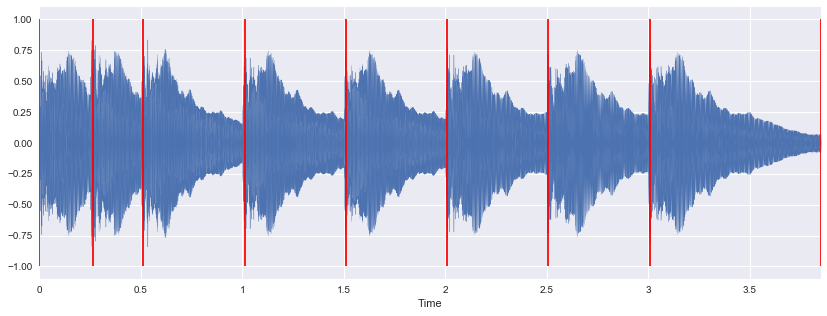

In [15]:
librosa.display.waveplot(x, sr=sr)
plt.vlines(onset_times, -1, 1, color='r')

## Step 2: Estimate Pitch

Estimate pitch using the autocorrelation method:

In [16]:
def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0

## Step 3: Generate Pure Tone

Create a function to generate a pure tone at the specified frequency:

In [17]:
def generate_sine(f0, sr, n_duration):
    n = numpy.arange(n_duration)
    return 0.2*numpy.sin(2*numpy.pi*f0*n/float(sr))

## Step 4: Put it together

Create a helper function for use in a list comprehension:

In [18]:
def estimate_pitch_and_generate_sine(x, onset_samples, i, sr):
    n0 = onset_samples[i]
    n1 = onset_samples[i+1]
    f0 = estimate_pitch(x[n0:n1], sr)
    return generate_sine(f0, sr, n1-n0)

Use a list comprehension to concatenate the synthesized segments:

In [19]:
y = numpy.concatenate([
    estimate_pitch_and_generate_sine(x, onset_boundaries, i, sr=sr)
    for i in range(len(onset_boundaries)-1)
])

Play the synthesized transcription.

In [20]:
ipd.Audio(y, rate=sr)

Plot the CQT of the synthesized transcription.

In [21]:
cqt = librosa.cqt(y, sr=sr)

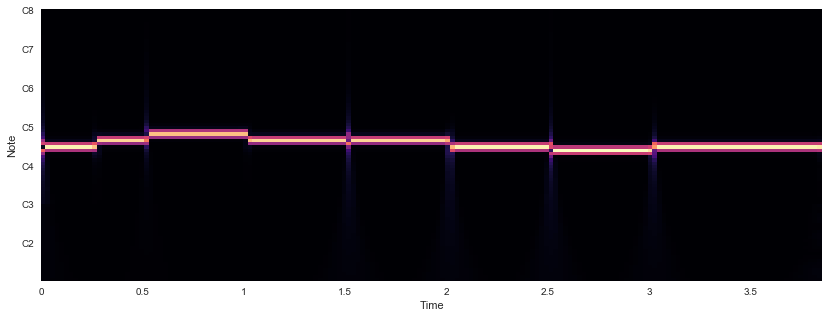

In [22]:
librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note')

[&larr; Back to Index](index.html)